# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from google.colab import drive
drive.mount('/content/drive')

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import matplotlib.image as mpimg

import os
import shutil
import random
import math

Mounted at /content/drive


# Additional functions

In [ ]:
def select_random_img(img_dir_path, txt_dir_path):
  files = os.listdir(img_dir_path)
  random_png = random.choice(files)

  png_path = img_dir_path + "/" + random_png
  txt_path = txt_dir_path + "/" + os.path.splitext(random_png)[0] + '.txt'

  return png_path, txt_path


def create_dataset(image_dir, label_dir):
    """
    Create tf.data.Dataset (img, (ymin, xmin, ymax, xmax)).
    """

    img_files = tf.io.gfile.glob(os.path.join(image_dir, '*.png'))

    img_files = sorted(img_files)

    def _map_fn(img_path):
        base_name = tf.strings.split(img_path, os.sep)[-1]
        base_name = tf.strings.split(base_name, '.')[0]

        txt_path = tf.strings.join([label_dir, '/', base_name, '.txt'])

        image = load_and_preprocess_image(img_path)
        x_center, y_center, w, h = get_coordinates_bounding_box(txt_path)

        bbox = tf.stack([compute_bbox(x_center, y_center, w, h)])

        return image, bbox

    dataset = tf.data.Dataset.from_tensor_slices(img_files)
    dataset = dataset.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

def load_and_preprocess_image(img_path, resize=True):
    """
    read PNG
    """
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)

    if resize: img = tf.image.resize(img, (224, 224))

    return img

def draw_bounding_box_on_image(image, bbox, color="red", thickness=6):
    draw = ImageDraw.Draw(image)

    left, top, right, bottom = bbox[1], bbox[0], bbox[3], bbox[2]
    draw.rectangle([left, top, right, bottom], outline=color, width=thickness)

    return image

def show_bounding_box_on_image(img_path, txt_path, *c):
  img = load_and_preprocess_image(img_path, resize=False)
  img = img.numpy()

  image_pil = Image.fromarray(np.uint8(img)).convert("RGB")

  image_width, image_height = image_pil.size
  x_center, y_center, w, h = get_coordinates_bounding_box(txt_path) if not c else map(float, c)

  bbox_pixels = compute_bbox(x_center, y_center, w, h, image_width, image_height)

  draw_bounding_box_on_image(image_pil,bbox_pixels)

  np.copyto(img, np.array(image_pil))

  display_img(np.array(image_pil))


def get_coordinates_bounding_box(txt_path):
  txt = tf.io.read_file(txt_path)
  lines = tf.strings.split(txt, '\n')

  first_line = lines[0]
  parts = tf.strings.split(first_line, ' ')

  class_id = tf.strings.to_number(parts[0], out_type=tf.int32)
  x_center = tf.strings.to_number(parts[1], out_type=tf.float32)
  y_center = tf.strings.to_number(parts[2], out_type=tf.float32)
  w        = tf.strings.to_number(parts[3], out_type=tf.float32)
  h        = tf.strings.to_number(parts[4], out_type=tf.float32)

  return x_center, y_center, w, h

def display_img(img, IoU=None):
  plt.imshow(img)
  plt.axis('off')
  if IoU: plt.figtext(0.5, 0.01, f"IoU = {IoU}", ha='center', fontsize=12)
  plt.show()

def get_png_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.size

def compute_bbox(x_center, y_center, w, h, image_width=1, image_height=1):
  xmin = (x_center - w/2) * image_width
  xmax = (x_center + w/2) * image_width
  ymin = (y_center - h/2) * image_height
  ymax = (y_center + h/2) * image_height
  bbox_pixels = ymin, xmin, ymax, xmax

  return bbox_pixels

# copy png and txt into train and valid directories
def copy_pairs(images_list, src_img_folder, src_txt_folder, dst_img_folder, dst_txt_folder):
    for img_name in images_list:
        base_name = os.path.splitext(img_name)[0]

        src_img_path = os.path.join(src_img_folder, img_name)

        txt_name = base_name + ".txt"
        src_txt_path = os.path.join(src_txt_folder, txt_name)


        dst_img_path = os.path.join(dst_img_folder, img_name)
        dst_txt_path = os.path.join(dst_txt_folder, txt_name)

        # copy files if it`s exisit
        if os.path.isfile(src_img_path) and os.path.isfile(src_txt_path):
            shutil.copy2(src_img_path, dst_img_path)
            shutil.copy2(src_txt_path, dst_txt_path)
        else:
            print(f"Увага! Не знайдено пару: {img_name} або {txt_name}")

def detect_img(model, img_path, txt_dir_path = None, color_pred = 'red', color_corr = 'green', thickness=2):
  IoU = None

  # prepair img for predict
  image_tensor = load_and_preprocess_image(img_path) # return 224x224 img
  image_batch = tf.expand_dims(image_tensor, axis=0) # add batch dimension because it`s single img
  pred = model.predict(image_batch)

  # get predicted bbox
  pred_bbox = pred[0]
  img_width, img_height = get_png_dimensions(img_path)
  ymin = int(pred_bbox[0] * img_height)
  xmin = int(pred_bbox[1] * img_width)
  ymax = int(pred_bbox[2] * img_height)
  xmax = int(pred_bbox[3] * img_width)
  pred_bbox_pixels = (ymin, xmin, ymax, xmax)

  #get img for drawing
  image_np = load_and_preprocess_image(png_path, False).numpy().astype(np.uint8)
  image_pil = Image.fromarray(image_np)

  #draw predicted bbox
  image_with_box = draw_bounding_box_on_image(image_pil, pred_bbox_pixels, color=color_pred, thickness=thickness)

  # add corr bbox to img if exist
  if txt_dir_path:
    # get txt path
    img_name = tf.strings.split(img_path, os.sep)[-1]
    img_name = tf.strings.split(img_name, '.')[0]
    txt_path = txt_dir_path + "/" + img_name + '.txt'

    # get true bbox
    x_center, y_center, w, h = get_coordinates_bounding_box(txt_path)
    label_bbox_pixels = compute_bbox(x_center, y_center, w, h, img_width, img_height)

    #draw true bbox
    image_with_box = draw_bounding_box_on_image(image_pil, label_bbox_pixels, color=color_corr, thickness=thickness)

    IoU = calculate_iou(pred_bbox_pixels, label_bbox_pixels)

  display_img(image_with_box, IoU)


def calculate_iou(box1, box2):
    # coordinates of intersection
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # area of each bbox
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

# simple mAP for object Localization
def simple_mAP(model, dataset, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    aps = []

    for iou_thresh in iou_thresholds:
        correct_detections = 0
        total_detections = 0

        for images, gt_bboxes in dataset:
            preds = model.predict(images, verbose=0)
            batch_size = preds.shape[0]

            for i in range(batch_size):
                pred_bbox = preds[i]

                gt_bbox_np = gt_bboxes[i].numpy()[0]

                iou = calculate_iou(pred_bbox, gt_bbox_np)

                total_detections += 1
                if iou >= iou_thresh:
                    correct_detections += 1

        ap = correct_detections / total_detections if total_detections > 0 else 0
        aps.append(ap)

    mAP = np.mean(aps)
    return mAP

def compare_models_visually(models_list, img_path, figsize=(12, 12)):
  predictions = []

  # prepair img for predict
  image_tensor = load_and_preprocess_image(img_path) # return 224x224 img
  image_batch = tf.expand_dims(image_tensor, axis=0) # add batch dimension because it`s single img

  img_width, img_height = get_png_dimensions(img_path)

  for model in models_list:

    pred = model[1].predict(image_batch, verbose=0)

    # get predicted bbox
    pred_bbox = pred[0]
    ymin = int(pred_bbox[0] * img_height)
    xmin = int(pred_bbox[1] * img_width)
    ymax = int(pred_bbox[2] * img_height)
    xmax = int(pred_bbox[3] * img_width)
    predictions.append((ymin, xmin, ymax, xmax))

  #draw imgs
  fig, axes = plt.subplots(3, math.ceil(len(models_list) / 3), figsize=figsize)
  if len(models_list) == 1:
      axes = [axes]
  else:
      axes = axes.flatten()

  for idx in range(len(models_list)):
    #get img for drawing
    image_np = load_and_preprocess_image(png_path, False).numpy().astype(np.uint8)
    image_pil = Image.fromarray(image_np)
    image_with_box = draw_bounding_box_on_image(image_pil, predictions[idx], color="blue")

    axes[idx].imshow(image_with_box)
    # axes[idx].axis('off')
    axes[idx].set_xlabel(models_list[idx][0], fontsize=12, labelpad=10)


  plt.tight_layout()
  plt.show()

def load_model(models_dir):
  files = os.listdir(models_dir)
  models = []

  for model_name in files:
    model_path = models_dir + '/' + model_name

    #load model
    model = tf.keras.models.load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
    models.append((model_name, model))

  print(models)
  return models


def compare_models_mAP(models_list, dataset):
  for model_name, model in models_list:
    print(f"{model_name} mAP: {simple_mAP(model=model, dataset=dataset)}")

def normalize_data(image, bbox):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, bbox

# Declare constants

In [ ]:
source_folder_txt = r"/content/drive/MyDrive/ML/datasets/Face_dataset/labels/train"
source_folder_png = r"/content/drive/MyDrive/ML/datasets/Face_dataset/images/train"

txt_destination_folder = r"/content/drive/MyDrive/ML/datasets/Face_dataset/labels/single_face"
png_destination_folder = r"/content/drive/MyDrive/ML/datasets/Face_dataset/images/single_face"

train_img_dir = r"/content/drive/MyDrive/ML/datasets/Face_dataset/images/train_single"
train_txt_dir = r"/content/drive/MyDrive/ML/datasets/Face_dataset/labels/train_single"

val_img_dir   = r"/content/drive/MyDrive/ML/datasets/Face_dataset/images/val_single"
val_txt_dir   = r"/content/drive/MyDrive/ML/datasets/Face_dataset/labels/val_single"

modeles_dir = "/content/drive/MyDrive/ML/datasets/Face_dataset/models"

#Select photos with one face

In [ ]:
os.makedirs(txt_destination_folder, exist_ok=True)
os.makedirs(png_destination_folder, exist_ok=True)

NameError: name 'os' is not defined

In [ ]:
if not os.path.exists(txt_destination_folder):

  for filename in os.listdir(source_folder_txt):

      if filename.endswith(".txt"):
          txt_path = os.path.join(source_folder_txt, filename)


          with open(txt_path, "r", encoding="utf-8") as f:
              lines = f.readlines()

          if len(lines) == 1:
              shutil.copy(txt_path, txt_destination_folder)

              base_name = os.path.splitext(filename)[0]
              png_filename = base_name + ".png"
              png_path = os.path.join(source_folder_png, png_filename)

              if os.path.exists(png_path):
                  shutil.copy(png_path, png_destination_folder)

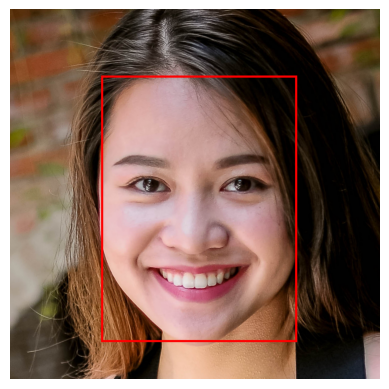

In [ ]:
png, txt = select_random_img(png_destination_folder, txt_destination_folder)
show_bounding_box_on_image(png, txt)

# Prepering data for train

Split data into validation and training datasets

In [ ]:
if not os.path.exists(train_img_dir) or not os.path.exists(train_txt_dir) or not os.path.exists(val_img_dir) or not os.path.exists(val_txt_dir):

  # create directories, if it`s dosent exist
  os.makedirs(train_img_dir, exist_ok=True)
  os.makedirs(train_txt_dir, exist_ok=True)
  os.makedirs(val_img_dir, exist_ok=True)
  os.makedirs(val_txt_dir, exist_ok=True)

  all_images = [f for f in os.listdir(png_destination_folder) if f.endswith('.png')]
  # shuffle images
  random.shuffle(all_images)

  split_ratio = 0.8
  split_index = int(len(all_images) * split_ratio)

  train_images = all_images[:split_index]
  val_images   = all_images[split_index:]

  # copy train`s part of datasets
  copy_pairs(train_images, png_destination_folder, txt_destination_folder,
            train_img_dir, train_txt_dir)

  # copy valid`s part of datasets
  copy_pairs(val_images, png_destination_folder, txt_destination_folder,
            val_img_dir, val_txt_dir)


Create dataset

In [ ]:
train_dataset = create_dataset(train_img_dir, train_txt_dir)
val_dataset   = create_dataset(val_img_dir,   val_txt_dir)

train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())

train_dataset = train_dataset.map(normalize_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(normalize_data, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.cache().shuffle(buffer_size=100).batch(16).prefetch(tf.data.AUTOTUNE) #prev^ 8 -- 16
val_dataset   = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)  #prev^ 8 -- 16

# Implement AlexNet for object detection

In [ ]:
model_alexNet = tf.keras.Sequential([
    tf.keras.layers.Conv2D(96, kernel_size=7, activation='relu', padding='valid', strides=1),
    tf.keras.layers.MaxPool2D((3,3), strides=2, padding='valid'),

    tf.keras.layers.Conv2D(256, (3,3), padding="same", activation="relu", strides=1),
    tf.keras.layers.MaxPool2D((3,3), strides=2, padding='valid'),

    tf.keras.layers.Conv2D(384, (3,3), padding="same", activation="relu", strides=1),
    tf.keras.layers.Conv2D(384, (3,3), padding="same", activation="relu", strides=1),
    tf.keras.layers.Conv2D(256, (3,3), padding="same", activation="relu", strides=1),
    tf.keras.layers.MaxPool2D((3,3), strides=2, padding='valid'),
    tf.keras.layers.GlobalAvgPool2D(),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=4096, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=4096, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(units=4, activation='linear')
])

model_alexNet.compile(optimizer=tf.keras.optimizers.Nadam(), loss='mse', metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model_alexNet.fit(train_dataset, epochs=100,
                    validation_data=val_dataset,
                    callbacks=[early_stopping_cb])

Epoch 1/100


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-55f262607dcd>", line 31, in <cell line: 0>
    history = model_alexNet.fit(train_dataset, epochs=100,
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function
    opt_outputs = multi_step_on_iterator(iterator)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-pac

TypeError: object of type 'NoneType' has no len()

# Use pretrain ResNet50

In [ ]:
ResNet50 = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


freeze the layers

In [ ]:
ResNet50.trainable = False

create top layers

In [ ]:
x = tf.keras.layers.GlobalAvgPool2D()(ResNet50.output)
x = tf.keras.layers.Dense(units=4096, kernel_initializer="he_normal")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(units=1024, kernel_initializer="he_normal")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(units=4, activation='linear')(x)

create entire model

In [ ]:
model_ResNet50 = tf.keras.Model(inputs=ResNet50.input, outputs=x)

train model

In [ ]:
model_ResNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model_ResNet50.fit(train_dataset, epochs=100,
                    validation_data=val_dataset,
                    callbacks=[early_stopping_cb])

Epoch 1/10
     96/Unknown 332s 3s/step - accuracy: 0.2920 - loss: 2.4495

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


96/96 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.2922 - loss: 2.4444 - val_accuracy: 0.3802 - val_loss: 3.8862
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 155ms/step - accuracy: 0.3718 - loss: 0.8997 - val_accuracy: 0.2708 - val_loss: 0.4385
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.4034 - loss: 0.5557 - val_accuracy: 0.6979 - val_loss: 0.1938
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 370ms/step - accuracy: 0.4617 - loss: 0.3582 - val_accuracy: 0.5625 - val_loss: 0.1495
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.4983 - loss: 0.2656 - val_accuracy: 0.4167 - val_loss: 0.0836
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.5095 - loss: 0.2053 - val_accuracy: 0.5729 - val_loss: 0.0644
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.5090 - loss: 0.1549 - val_accuracy: 0.7760 - val_loss: 0.0406
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.5601 - loss: 0.1220 - val_accuracy: 0.8490 

# Use pretrain EfficientNet B3

In [ ]:
EfficientNetB3 = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3))

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


freeze the layers

In [ ]:
EfficientNetB3.trainable = False

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(EfficientNetB3.output)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(1024, activation='relu')(x) # prev 512
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x) #prev 256
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(4, activation='linear')(x)

In [ ]:
model_EfficientNetB3 = tf.keras.Model(inputs=EfficientNetB3.input, outputs=x)

In [ ]:
model_EfficientNetB3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
tensor_board_cb = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/ML/datasets/Face_dataset/models/Callbacks', histogram_freq=1)

history = model_EfficientNetB3.fit(train_dataset, epochs=100,
                    validation_data=val_dataset,
                    callbacks=[early_stopping_cb, early_stopping_cb])

Epoch 1/100
     48/Unknown 521s 7s/step - accuracy: 0.3061 - loss: 1.5533

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 785s 13s/step - accuracy: 0.3075 - loss: 1.5424 - val_accuracy: 0.7240 - val_loss: 0.2449
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 74s 788ms/step - accuracy: 0.5144 - loss: 0.2760 - val_accuracy: 0.8385 - val_loss: 0.2051
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 326ms/step - accuracy: 0.5997 - loss: 0.1113 - val_accuracy: 0.8646 - val_loss: 0.1674
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.6317 - loss: 0.0745 - val_accuracy: 0.9167 - val_loss: 0.1173
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.7097 - loss: 0.0614 - val_accuracy: 0.9167 - val_loss: 0.0731
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 295ms/step - accuracy: 0.7408 - loss: 0.0643 - val_accuracy: 0.9167 - val_loss: 0.0522
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - accuracy: 0.7409 - loss: 0.0410 - val_accuracy: 0.9167 - val_loss: 0.0295
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 727ms/step - accuracy: 0.7951 - loss: 0.0454 - val_accuracy:

# Load model

In [ ]:
loaded_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/ML/datasets/Face_dataset/my_models/resnet50_model_4_trainable_par.h5',
    custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
)

# Define model for testing

In [ ]:
model = model_EfficientNetB3

# Evaluate model

#### Show model`s prediction

In [ ]:
model.evaluate(val_dataset)

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 538ms/step - accuracy: 0.7907 - loss: 0.0144


[0.007615500595420599, 0.9166666865348816]

In [ ]:
simple_mAP(model=model, dataset=val_dataset)

np.float64(0.4296875)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


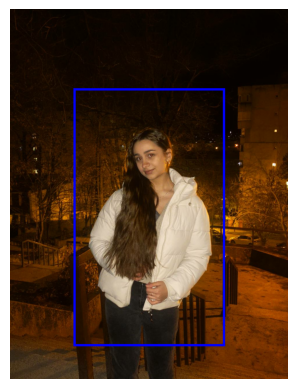

In [ ]:
png_path, txt_path = select_random_img(png_destination_folder, txt_destination_folder)
png_path = "/content/drive/MyDrive/ML/datasets/Face_dataset/images/my_img/2.png"
detect_img(model=model, img_path=png_path, txt_dir_path=None, thickness=8, color_pred='blue')

# Save model

In [ ]:
model.save(modeles_dir + '/EfficientNetB3_model_3_gpt_arch_300_size.h5')

#Compare models

In [ ]:
models = load_model(models_dir=modeles_dir)

[('alex_model_1.h5', <Sequential name=sequential_1, built=True>), ('alex_model_2.h5', <Functional name=functional_19, built=True>), ('resnet50_model_1.h5', <Functional name=functional_19, built=True>), ('resnet50_model_2.h5', <Functional name=functional_1, built=True>), ('resnet50_model_3_ChA.h5', <Functional name=functional, built=True>), ('resnet50_model_4_trainable_par.h5', <Functional name=functional_1, built=True>), ('resnet50_model_5_no_weights.h5', <Functional name=functional, built=True>), ('EfficientNetB3_model_1.h5', <Functional name=functional, built=True>), ('EfficientNetB3_model_2_gpt_arch.h5', <Functional name=functional_21, built=True>), ('EfficientNetB3_model_3_gpt_arch_300_size.h5', <Functional name=functional_1, built=True>)]


In [ ]:
compare_models_mAP(models, val_dataset)

alex_model_1.h5 mAP: 0.33541666666666664
alex_model_2.h5 mAP: 0.4979166666666666
resnet50_model_1.h5 mAP: 0.4979166666666666
resnet50_model_2.h5 mAP: 0.4453124999999999
resnet50_model_3_ChA.h5 mAP: 0.3359375
resnet50_model_4_trainable_par.h5 mAP: 0.5057291666666666
resnet50_model_5_no_weights.h5 mAP: 0.3359375


In [ ]:
png_path = "/content/drive/MyDrive/ML/datasets/Face_dataset/images/my_img/8.png"
compare_models_visually(models_list=models, img_path=png_path)

ValueError: Input 0 of layer "functional_19" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 300, 300, 3)